In [1]:
# Import required libraries and dependencies
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import hvplot.pandas
import numpy as np

In [2]:
# Load the data into a Pandas DataFrame and make the index the "coin_id" column.
market_data_df = pd.read_csv("Resources/crypto_market_data.csv", index_col="coin_id")

# Display sample data
market_data_df.head(10)

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384
binancecoin,2.10423,12.85511,6.80688,0.05865,36.33486,155.61937,69.69195
chainlink,-0.23935,20.69459,9.30098,-11.21747,-43.69522,403.22917,325.13186
cardano,0.00322,13.99302,5.55476,10.10553,-22.84776,264.51418,156.09756
litecoin,-0.06341,6.60221,7.28931,1.21662,-17.23960,27.49919,-12.66408


In [3]:
# Generate summary statistics
market_data_df.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


### Prepare the Data

In [4]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
scaled_data = StandardScaler().fit_transform(market_data_df)

In [5]:
# Create a DataFrame with the scaled data
scaled_data = pd.DataFrame(scaled_data, columns=market_data_df.columns, index=market_data_df.index)

# Copy the crypto names from the original data


# Set the coinid column as index


# Display sample data
scaled_data.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317


### Find the Best Value for k Using the Original Scaled DataFrame.

In [6]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
inertia = []
k = list(range(1, 11))

# Create an empty list to store the inertia values


# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using the scaled DataFrame
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(scaled_data)
    inertia.append(k_model.inertia_)

# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Create a DataFrame with the data to plot the Elbow curve


# Display the DataFrame
df_elbow

,k,inertia
0,1,287.000000
1,2,198.571818
2,3,123.190482
3,4,79.022435
4,5,68.243549
5,6,61.096844
6,7,50.255840
7,8,40.888474
8,9,32.768762
9,10,29.090066


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

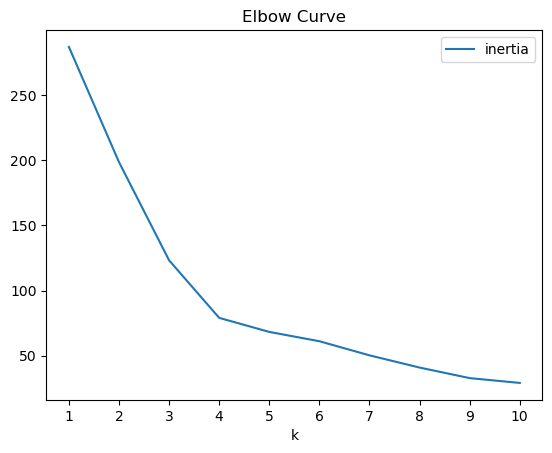

In [7]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
df_elbow.plot(x="k", y="inertia", title="Elbow Curve", xticks=k)

#### Answer the following question: 
**Question:** What is the best value for `k`?

**Answer:** Presumably 4

### Cluster Cryptocurrencies with K-means Using the Original Scaled Data.

In [8]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=4, n_init='auto', random_state=0)

In [9]:
# Fit the K-Means model using the scaled data
model.fit(scaled_data)

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [10]:
# Predict the clusters to group the cryptocurrencies using the scaled data
data_predictions = model.predict(scaled_data)

# View the resulting array of cluster values.
data_predictions

array([0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 3, 2, 3, 3, 3, 3])

In [11]:
# Create a copy of the DataFrame
predictions_df = scaled_data.copy()

In [12]:
# Add a new column to the DataFrame with the predicted clusters
predictions_df["crypto_clusters"] = data_predictions

# Display sample data
predictions_df.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,crypto_clusters
coin_id,,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637,0
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352,0
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061,3
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546,3
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317,0


<Axes: title={'center': 'Crypto Clusters'}, xlabel='price_change_percentage_24h', ylabel='price_change_percentage_7d'>

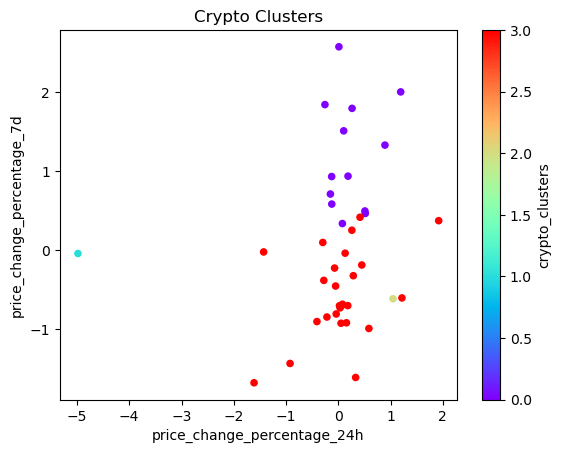

In [13]:
# Create a scatter plot using Pandas plot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`.
# Use "rainbow" for the color to better visualize the data.
predictions_df.plot.scatter(x="price_change_percentage_24h",
                             y="price_change_percentage_7d",
                               c="crypto_clusters",
                                 colormap="rainbow",
                                   title="Crypto Clusters")


### Optimize Clusters with Principal Component Analysis.

In [14]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

In [15]:
# Use the PCA model with `fit_transform` on the original scaled DataFrame to reduce to three principal components.
pca_data = pca.fit_transform(scaled_data)

# View the first five rows of the DataFrame. 
pca_data[:5]

array([[-0.60066733,  0.84276006,  0.46159457],
       [-0.45826071,  0.45846566,  0.95287678],
       [-0.43306981, -0.16812638, -0.64175193],
       [-0.47183495, -0.22266008, -0.47905316],
       [-1.15779997,  2.04120919,  1.85971527]])

In [16]:
# Retrieve the explained variance to determine how much information  can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.3719856 , 0.34700813, 0.17603793])

#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** 

In [17]:
# Create a new DataFrame with the PCA data.
# Note: The code for this step is provided for you
pca_df = pd.DataFrame(
    data=pca_data, columns=["PCA1", "PCA2", "PCA3"],
      index=market_data_df.index
)
# Creating a DataFrame with the PCA data


# Copy the crypto names from the original data


# Set the coinid column as index


# Display sample data
pca_df.head(10)

,PCA1,PCA2,PCA3
coin_id,,,
bitcoin,-0.600667,0.842760,0.461595
ethereum,-0.458261,0.458466,0.952877
tether,-0.433070,-0.168126,-0.641752
ripple,-0.471835,-0.222660,-0.479053
bitcoin-cash,-1.157800,2.041209,1.859715
binancecoin,-0.516534,1.388377,0.804071
chainlink,-0.450711,0.517699,2.846143
cardano,-0.345600,0.729439,1.478013
litecoin,-0.649468,0.432165,0.600303


### Find the Best Value for k Using the PCA Data

In [18]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
inertia = []
k = list(range(1, 11))

# Create an empty list to store the inertia values


# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using PCA DataFrame.
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(pca_df)
    inertia.append(k_model.inertia_)

# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Create a DataFrame with the data to plot the Elbow curve


# Display the DataFrame
df_elbow

,k,inertia
0,1,256.874086
1,2,168.811896
2,3,93.774626
3,4,49.665497
4,5,39.174439
5,6,32.453229
6,7,21.194032
7,8,19.501286
8,9,13.681140
9,10,12.449390


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

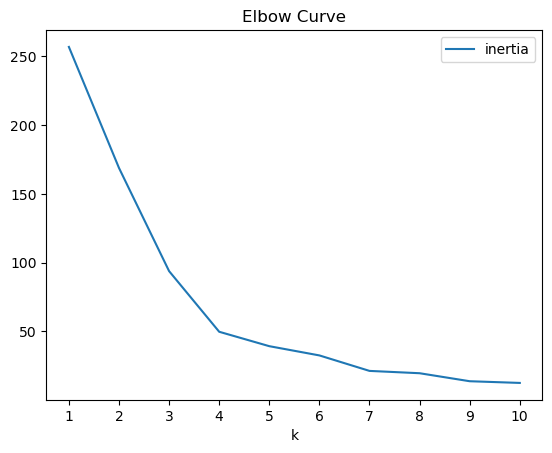

In [19]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
df_elbow.plot(x="k", y="inertia", title="Elbow Curve", xticks=k)

#### Answer the following questions: 
* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** 4


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** No

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [20]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=4, n_init='auto', random_state=0)

In [21]:
# Fit the K-Means model using the PCA data
model.fit(pca_df)

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [22]:
# Predict the clusters to group the cryptocurrencies using the PCA data
pcadata_predictions = model.predict(pca_df)

# Print the resulting array of cluster values.
print(pcadata_predictions)

[0 0 3 3 0 0 0 0 0 3 3 3 3 0 3 0 3 3 0 3 3 0 3 3 3 3 3 3 0 3 3 3 1 0 3 3 2
 3 3 3 3]


In [23]:
# Create a copy of the DataFrame with the PCA data
pca_predictions_df = pca_df.copy()

# Add a new column to the DataFrame with the predicted clusters
pca_predictions_df["crypto_clusters"] = pcadata_predictions

# Display sample data
pca_predictions_df.head()

,PCA1,PCA2,PCA3,crypto_clusters
coin_id,,,,
bitcoin,-0.600667,0.842760,0.461595,0
ethereum,-0.458261,0.458466,0.952877,0
tether,-0.433070,-0.168126,-0.641752,3
ripple,-0.471835,-0.222660,-0.479053,3
bitcoin-cash,-1.157800,2.041209,1.859715,0


In [24]:
# Create a scatter plot using hvPlot by setting `x="PCA1"` and `y="PCA2"`. 
pca_predictions_df.hvplot.scatter(x="PCA1", y="PCA2", by="crypto_clusters", hover_cols=["coinid"])

:NdOverlay   [crypto_clusters]
   :Scatter   [PCA1]   (PCA2)

### Determine the Weights of Each Feature on each Principal Component

In [26]:
# Use the columns from the original scaled DataFrame as the index.
pca_weights_df = pd.DataFrame(np.transpose(pca.components_), columns=["PCA1", "PCA2", "PCA3"], index=scaled_data.columns)
pca_weights_df

,PCA1,PCA2,PCA3
price_change_percentage_24h,-0.416728,0.358162,-0.218795
price_change_percentage_7d,-0.102432,0.227432,0.787670
price_change_percentage_14d,-0.009162,0.540415,0.349534
price_change_percentage_30d,0.191523,0.562182,-0.181744
price_change_percentage_60d,0.320365,0.434040,-0.361377
price_change_percentage_200d,0.594468,0.027735,0.039733
price_change_percentage_1y,0.568379,-0.150789,0.210541


#### Answer the following question: 

* **Question:** Which features have the strongest positive or negative influence on each component? 
 
* **Answer:** 

PCA1


Stongest = 200d at 0.594468 & 1y at 0.568379

Weakest = 24h at -0.416728


PCA2

Stongest = 30d at 0.562182 & 14d at 0.540415

Weakest = 1y at -0.150789

PCA3

Stongest = 7d at 0.787670 

Weakest = 60d at -0.361377